<a href="https://colab.research.google.com/github/HSE-LAMBDA/MLDM-2020/blob/master/day-08/MLDM_2020_seminar08_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)

2.4.0


# Task 1: maximum likelihood fit (3 points)

Let's generate a Gaussian mixture dataset and then fit its parameters with maximum likelihood.

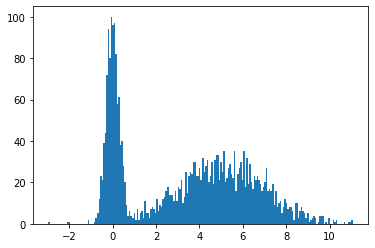

In [6]:
X1 = np.random.normal(size=1000, scale=0.3).astype('float32')
X2 = np.random.normal(size=2000, loc=5., scale=2.).astype('float32')

X = np.concatenate([X1, X2])
np.random.shuffle(X)
plt.hist(X, bins=200);

**Task**:
 - fill the gaps below to perform the max. likelihood fit with the pdf:
$$\text{PDF}(x|\mu_1, \sigma^2_1, \mu_2, \sigma^2_2, \alpha)
= \alpha\cdot\mathscr{N}(x|\mu_1, \sigma_1^2) + (1 - \alpha)\cdot\mathscr{N}(x|\mu_2, \sigma_2^2)$$
 - what the fitted values of $\mu_1, \sigma^2_1, \mu_2, \sigma^2_2$ and $\alpha$ should be? does your fit converge to them?

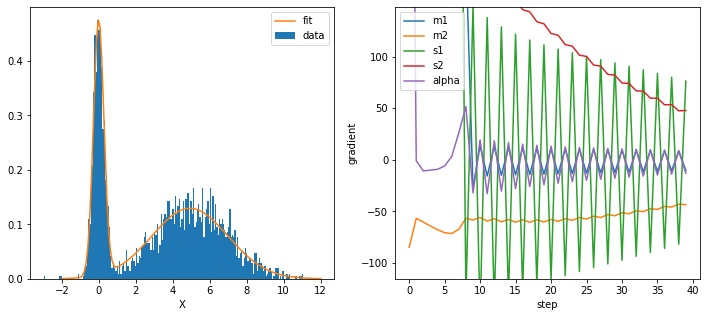

[<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=-0.005519535>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=4.9287243>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.28196117>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.0592113>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.331785>]


In [7]:
from IPython.display import clear_output
import math
import random


# Defining Gaussian PDF using tf functions
def gaussian(x, mu, stdev):
  return tf.exp(-1/2 * (x - mu)**2 / stdev**2) / (tf.math.sqrt(2*tf.constant(math.pi))*stdev) 
  # use tf.exp for the exponent, don't forget the normalization

# Arbitrary mixture PDF
def mixture(x, f1, f2, alpha):
  return alpha * f1(x) + (1. - alpha) * f2(x)

# Parameters that we'd like to infer (with an initial guess)
m1    = tf.Variable(0.3)
m2    = tf.Variable(4.7)
s1    = tf.Variable(0.9)
s2    = tf.Variable(2.6)
alpha = tf.Variable(0.4)

# At each gradient update we'll apply this function to
# ensure valid parameter values
def apply_constraints():
  if s1 <= 0.001:
    s1.assign(0.001)
  if s2 <= 0.001:
    s2.assign(0.001)
  if alpha < 0:
    alpha.assign(0.001)
  if alpha > 1:
    alpha.assign(0.999)

      # ensure the sigmas are positive (greater or equal to some small
      # positive number, e.g. 1e-5) and alpha is in (0, 1) interval
      # hint: use the `assign` method to update the variable values


variables = [m1, m2, s1, s2, alpha]
#print(variables)

# Defining the overall PDF
def model_pdf(x):
  return mixture(x,
                 lambda t: gaussian(t, m1, s1),
                 lambda t: gaussian(t, m2, s2),
                 alpha)

# Log likelihood
def loglike(x):
  return -tf.math.log(model_pdf(x)) # hint: the logarithm is in tf.math.log

learning_rate = 0.0001
grad_history = [] # to keep track of gradient values at different steps


for i in range(40):
  with tf.GradientTape() as t:
    # NOTE: if `variable` was created with `trainable=False`, you need to
    # manually add it to the tape by calling `t.watch(variable)`. By default
    # the variable are created with `trainable=True`

    # Forward pass:
    l = loglike(X)
  

  # Backprop:
  grads = t.gradient(l, variables) # Calculate the gradients
  grad_history.append([g.numpy() for g in grads])
  
  # Gradient ascent step:
              # Apply the gradients manually (add
              # `learning_rate * corresponding_gradient` to
              # each variable)
  for i in range(len(grads)):
    variables[i].assign(variables[i] - learning_rate * grads[i])

  apply_constraints()

  # Do some plotting
  plt.figure(figsize=(12, 5))

  plt.subplot(1, 2, 1)
  plt.hist(X, bins=200, density=True, label='data')
  x_grid = np.linspace(-2, 12, 150)
  plt.plot(x_grid, model_pdf(x_grid), label='fit')
  plt.legend()
  plt.xlabel('X')

  plt.subplot(1, 2, 2)
  lines = plt.plot(np.array(grad_history))
  low = min(grad_history[-1])
  high = max(grad_history[-1])
  plt.ylim(low  - (high - low) * 0.6,
           high + (high - low) * 0.6)
  plt.legend(lines, ['m1', 'm2', 's1', 's2', 'alpha'])
  plt.xlabel('step')
  plt.ylabel('gradient')
  plt.show()
  print(variables)
  clear_output(wait=True);

# Task 2: classifying clothes (3 points)

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteZY8HGO/fashion_mnist-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteZY8HGO/fashion_mnist-test.tfrecord


Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.
[['Pullover' 'Trouser' 'Bag' 'Coat' 'Trouser']
 ['Ankle boot' 'Pullover' 'Pullover' 'T-shirt/top' 'Pullover']
 ['Shirt' 'Ankle boot' 'T-shirt/top' 'Sneaker' 'Sandal']
 ['Coat' 'T-shirt/top' 'Trouser' 'Bag' 'T-shirt/top']
 ['Coat' 'Pullover' 'Shirt' 'Sneaker' 'T-shirt/top']]


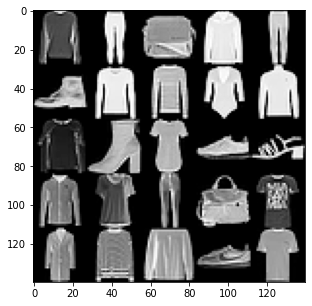

In [8]:
import tensorflow_datasets as tfds

data_train = tfds.load(name="fashion_mnist", split="train").prefetch(60000).cache()
data_test  = tfds.load(name="fashion_mnist", split="test" ).prefetch(10000).cache()

# Array for decoding the categories
label_names = np.array(['T-shirt/top',
                        'Trouser',
                        'Pullover',
                        'Dress',
                        'Coat',
                        'Sandal',
                        'Shirt',
                        'Sneaker',
                        'Bag',
                        'Ankle boot'])

# Get a single data batch of 25 images
sample_data = next(iter(data_train.batch(25)))
sample_images = sample_data['image']
sample_labels = sample_data['label']

# Plot the images in a 5x5 grid
plt.figure(figsize=(5, 5))
plt.imshow(
    sample_images.numpy().reshape(5, 5, 28, 28).transpose((0, 2, 1, 3)).reshape(140, 140),
    cmap='gray'
)
# Print corresponding labels
print(label_names[sample_labels.numpy().reshape(5, 5)])

**Task**:

Train a model which is an average of two models with different numbers of layers on the Fashion MNIST dataset, e.g.:

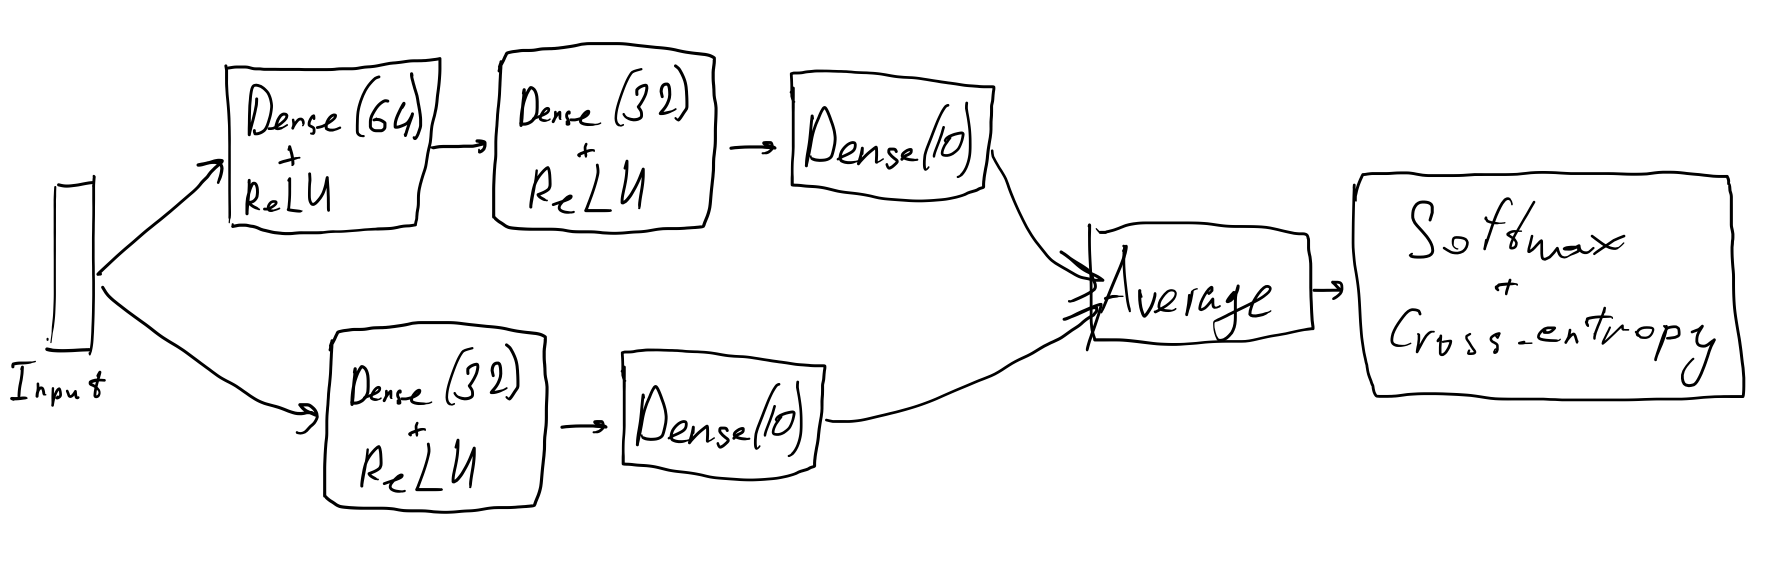

You can:
 - either use low-level API for that (still using `tf.keras.Sequential` models as building blocks)
 - or use `tf.keras.Model` for an arbitrary model (see examples from https://www.tensorflow.org/api_docs/python/tf/keras/Model)

In [9]:
train = next(iter(data_train.batch(60000)))
test = next(iter(data_train.batch(10000)))

train_X = train['image']
train_y = train['label']
test_X = test['image']
test_y = test['label']


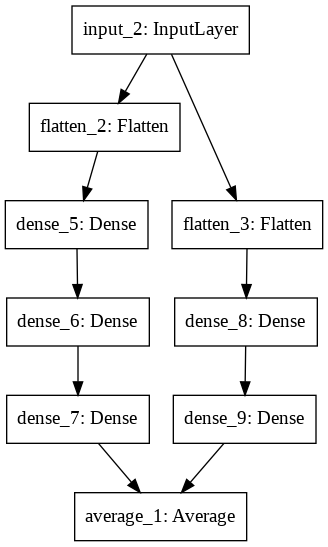

In [16]:
inputs = tf.keras.Input(shape=(28,28))

x = tf.keras.layers.Flatten()(inputs)
x = tf.keras.layers.Dense(64, activation = 'relu')(x)
x = tf.keras.layers.Dense(32, activation = 'relu')(x)
x = tf.keras.layers.Dense(10)(x)

y = tf.keras.layers.Flatten()(inputs)
y = tf.keras.layers.Dense(32, activation = 'relu')(y)
y = tf.keras.layers.Dense(10)(y)

outputs =  tf.keras.layers.Average()([x, y])

model = tf.keras.Model(inputs=inputs, outputs=outputs)

tf.keras.utils.plot_model(model, "my_first_model.png")


In [17]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 784)          0           input_2[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 64)           50240       flatten_2[0][0]                  
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 784)          0           input_2[0][0]                    
____________________________________________________________________________________________

In [11]:
predictions = model(sample_images).numpy()

tf.nn.softmax(predictions).numpy()

loss_fu = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss_fu(sample_labels , predictions).numpy()

104.28769

In [12]:
model.compile(optimizer='adam',
              loss=loss_fu,
              metrics=['accuracy'])

model.fit(train_X, train_y, epochs=30)



Epoch 1/30
1875/1875 [==============================] - 5s 2ms/step - loss: 5.1700 - accuracy: 0.7042
Epoch 2/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5786 - accuracy: 0.8082
Epoch 3/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5186 - accuracy: 0.8243
Epoch 4/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4677 - accuracy: 0.8376
Epoch 5/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4466 - accuracy: 0.8408
Epoch 6/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4265 - accuracy: 0.8483
Epoch 7/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4091 - accuracy: 0.8547
Epoch 8/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3876 - accuracy: 0.8597
Epoch 9/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3843 - accuracy: 0.8648
Epoch 10/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.372

In [13]:
from sklearn.metrics import accuracy_score

predictions = model(test_X).numpy()
predict_classes = np.argmax(predictions, axis =1)

loss_fu = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
test_accuracy = accuracy_score(predict_classes, test_y)

print('Test Loss: ',loss_fu(test_y , predictions).numpy())
print('Test Accuracy: ' , test_accuracy)


Test Loss:  0.31634927
Test Accuracy:  0.8865
